In [4]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from os import getenv
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import pickle

load_dotenv(".env")

True

In [5]:
def get_data(station_id):
    # Load database connection parameters

    PASSWORD = getenv("PASSWORD")
    
    host_name = 'localhost'
    username = 'root'
    password = PASSWORD
    database_name = "dublinbikes"

    # Create the SQLAlchemy engine
    engine = create_engine(f'mysql+pymysql://{username}:{password}@{host_name}/{database_name}')
    
    # SQL query
    query = f"""
    SELECT S.station_id, S.bike_stands, A.last_update, A.available_bikes, A.available_bike_stands,
           W.temperature, W.humidity, W.weather_condition, W.wind_speed
    FROM station S
    JOIN availability A ON S.station_id = A.station_id
    JOIN weather_data W ON A.station_id = W.station_id AND W.last_update = A.last_update
    WHERE S.station_id = {station_id};
    """
    
    # Execute the query and load the data into a DataFrame
    df = pd.read_sql(query, engine)
    # print(df)
    return df

def clean_data(df):
    # Convert 'last_update' from UNIX time in milliseconds to datetime and set as index
    df['last_update'] = pd.to_datetime(df['last_update'], unit='ms')
    df.set_index('last_update', inplace=True)

    # Add day_of_the_week (0 = Monday, 6 = Sunday)
    df['day_of_the_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['is_weekend'] = df['day_of_the_week'].apply(lambda x: 1 if x >= 5 else 0)

    
    # Convert temperature from Kelvin to Celsius
    df['temperature'] = df['temperature'] - 273.15
    
    # Aggregate numeric fields by mean and 'weather_condition' by mode
    df_numeric = df.drop(columns=['weather_condition']).resample('5min').mean()
    weather_condition_mode = df['weather_condition'].resample('5min').apply(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
    
    # Combine the aggregated data
    df_hourly = df_numeric
    df_hourly['weather_condition'] = weather_condition_mode
    
    # Factorize the 'weather_condition' to turn it into a numeric variable
    df_hourly['weather_condition_encoded'] = pd.factorize(df_hourly['weather_condition'])[0]
    df_hourly.dropna(inplace=True)
    return df_hourly



def predict(df_hourly):
    X = df_hourly[['day_of_the_week', 'hour', 'weather_condition_encoded', 'is_weekend', 'temperature','humidity','wind_speed']]
    y = df_hourly['available_bikes']
    z = df_hourly['available_bike_stands']
    
    # Temporal train-test split
    y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.2, random_state=42)
    z_train, z_test, X_train, X_test = train_test_split(z, X, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and fit the KNN Regressors and predict the target values
    knn_regressor_bikes = KNeighborsRegressor(n_neighbors=5)
    knn_regressor_bikes.fit(X_train_scaled, y_train)
    y_pred = knn_regressor_bikes.predict(X_test_scaled)

    knn_regressor_stands = KNeighborsRegressor(n_neighbors=5)
    knn_regressor_stands.fit(X_train_scaled, z_train)
    z_pred = knn_regressor_stands.predict(X_test_scaled)

    
    return knn_regressor_bikes, y_test, y_pred, knn_regressor_stands, z_test, z_pred


def evaluate(y_test, y_pred, verbose=True):
    # Calculate and display performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    
    # Plot the true vs predicted values
    if verbose:
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"R-squared (R²): {r2}")

    
def calculate_acc(acceptable_error,pred, test):
    
    # Calculate the absolute errors
    absolute_errors = np.abs(pred - test)
    
    # Determine the percentage of predictions within the acceptable error margin
    accurate_predictions = (absolute_errors <= acceptable_error).mean()
    
    # Convert to percentage
    accuracy_percentage = accurate_predictions * 100
    return accuracy_percentage
    # print(f"Model 'accuracy' within ±{acceptable_error} bikes: {accuracy_percentage:.2f}%")

In [6]:


accuracies_bikes = {}
accuracies_stands = {}

for i in range(1,117):
    df = get_data(station_id=i)
    
    if not df.empty:
        
        df_hourly = clean_data(df)
    
        model_bikes, y_test, y_pred, model_stands, z_test, z_pred = predict(df_hourly) 
        
        evaluate(y_test, y_pred, False)
        acc_bikes = calculate_acc(acceptable_error = 2, pred = y_pred, test = y_test)
        accuracies_bikes[i] = acc_bikes
        f_name_bikes = f"./web/models/model{i}_bikes.pkl"

        evaluate(z_test, z_pred, False)
        acc_stands = calculate_acc(acceptable_error = 2, pred = z_pred, test = z_test)
        accuracies_stands[i] = acc_stands
        f_name_stands = f"./web/models/model{i}_stands.pkl"

        with open(f_name_bikes,'wb') as handle1:
            pickle.dump(model_bikes,handle1,pickle.HIGHEST_PROTOCOL)

        with open(f_name_stands,'wb') as handle2:
            pickle.dump(model_stands,handle2,pickle.HIGHEST_PROTOCOL)




84.71019874013348


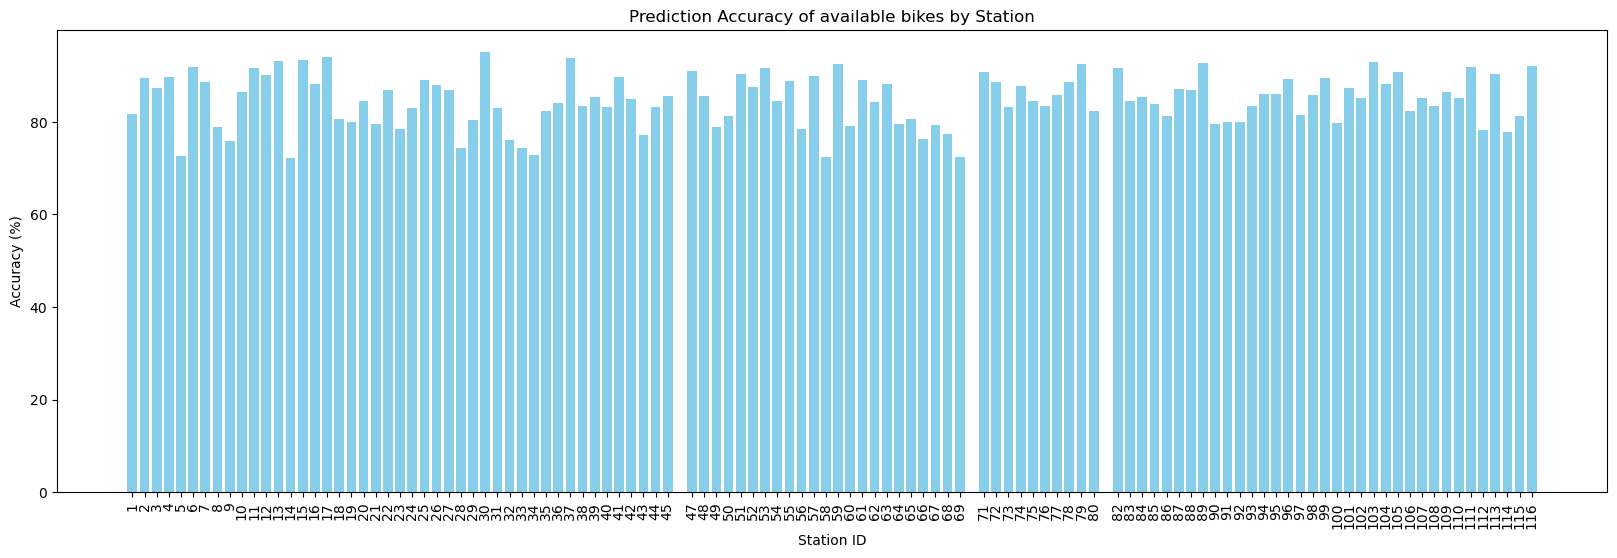

In [7]:
# Extracting station IDs and their accuracies
stations = list(accuracies_bikes.keys())
accuracy_values = list(accuracies_bikes.values())
print(np.mean(accuracy_values))
# Plotting
plt.figure(figsize=(20, 6))
plt.bar(stations, accuracy_values, color='skyblue')

plt.xlabel('Station ID')
plt.ylabel('Accuracy (%)')
plt.title('Prediction Accuracy of available bikes by Station')
plt.xticks(stations, rotation='vertical')

plt.show()

84.66171166865898


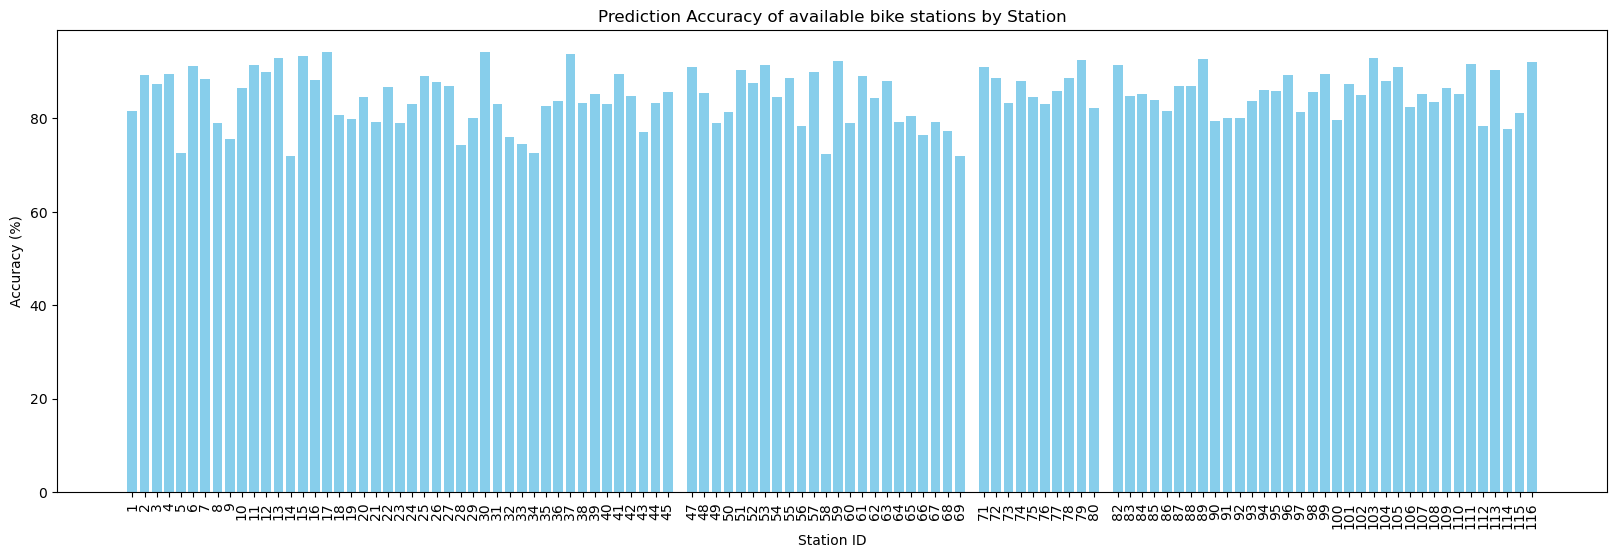

In [8]:
# Extracting station IDs and their accuracies
stations = list(accuracies_stands.keys())
accuracy_values = list(accuracies_stands.values())
print(np.mean(accuracy_values))
# Plotting
plt.figure(figsize=(20, 6))
plt.bar(stations, accuracy_values, color='skyblue')

plt.xlabel('Station ID')
plt.ylabel('Accuracy (%)')
plt.title('Prediction Accuracy of available bike stations by Station')
plt.xticks(stations, rotation='vertical')

plt.show()